### MLGeo23 Petro Pixel Poppers Project documentation

Please see the [root](./ESS469_Project_ML.ipynb) document for navigation.


# Data Preprocessing

Here we:

1. Access RAW and labels data and metadata
2. Create a labelled dataset
3. Create a datastructure in HDF5 file format
4. Store all datasets in a hierarchical structure.

For each thin section, we first load all maps and labels into a list, using the filenames as keys and the numpy arrays of the data as the values.
Next, we want to extract the element names and mineral names from the map and mask filenames.
Then, we want to extract the pixel coordinates and add them to the list.
We then reshape the data such that each pixel has its own row and all the map data is stored in a _feature vector_ for each pixel.


## Introduction


#### File format


We are using [**HDF5**]() to store our raw and processed data, because it is well-integrated with python, works well and efficiently for large, numerical data, and allows us to store several pandas DataFrames in one file with labels, making it easy to access and recast the data. With this in mind, the data is divided by thin section, and subdivided into DataFrames in the same hierarchy as the `./data/` directory, with additional labeled DataFrames added for processed data.

| **Data type** | description | dimensions |
| ------------- | ----------- | ---------- |
| RAW/          | ...         | ...        |
| labels/       | ...         | ...        |
| ...           | ...         | ...        |

#### Some basic h5py commands

If you accidentally try to git push a large HDF5 file, [look here](https://stackoverflow.com/questions/33360043/git-error-need-to-remove-large-file) _before_ you try to fix it with more commits.

If you encounter an error while running code with an HDF5 open, the file will stay open. You have to pass a `filename.close()` in order to be able to start fresh and rerun the code. One way to do this is to put `filename.close()` at the beginning of a codeblock, before `with h5py.File(.....)`.


In [1]:
# # HDF5 and h5py basics. 

# filename.close()

# # Open/Create an HDF5 file
# file_path = 'your_file.h5'
# file = h5py.File(file_path, 'a')  # 'a' stands for read/write mode, 'w' for write mode, 'r' for read mode. use read mode if possible

# # Create a group
# group = file.create_group(group_name)

# # Create a dataset
# data = [1, 2, 3]
# dataset = file.create_dataset(dataset_name, data=data)

# # Create a dataset in a group
# group_dataset = group.create_dataset(group_dataset_name, data=data)

# # Require_dataset or require_group instead of create_ if you want to a) create it if it doesn't exist, and access it if it does exist. 
# group_dataset = group.create_dataset(group_dataset_name, shape=data.shape, dtype=data.dtype data=data)

# # Access a group, access a dataset
# a_group = file['your_group']
# a__dataset = file['your_dataset']
# b_dataset = a_group['other_dataset']

# # Access values in a dataset
# values = a_dataset[:]  # Get all values
# single_value = a_dataset[0]  # Get a specific value

# # OR!!
# # In order to know which array is which in a dataset, access the names of the columns as follows:
# # Access the dtype and get the names out of it
# dtype = existing_dataset.dtype
# column_names = dtype.names

# # then, you can use these names to access the data:
# values = a_dataset['column_name1']  # Get all values
# row_values_as_tuples = a__dataset['column_name1'][0]

# # Close the file
# file.close()

## 0. Packages


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.ticker
plt.rcParams['text.usetex'] = True
import os
import tables as tt
# for navigation
import pandas as pd

# for file creation
import h5py
# open .tifs
from PIL import Image
from tifffile import imread

%matplotlib inline

## 1. Collect filenames and metadata


All of the information needed to organize the data is in files themselves, as well the filenames.
Let's start by collecting all this information in a dictionary.


In [3]:
# where's the data?
datafolder = '../Aikin_Data'
# metadata dictionary
meta = {}

**Thin sections**. We'll use **(TS1A, TS1B, TS2A, TS2B)** as names for first and second thin sections from the two hot (Upper Granite Gorge) and two cold block samples, respectively (H1, H2, C1, C2).


In [4]:
# what are the folder names in the data folder? (alphabetical)
ts_fnames = sorted([entry for entry in os.listdir(datafolder) 
                if os.path.isdir(os.path.join(datafolder, entry)) and 'DS_Store' not in entry])
meta['ts_filenames'] = ts_fnames

# how many thin sections are there?
ts_count = len(ts_fnames)

meta['ts_count'] = ts_count

# let's also establish some more compact naming
ts_names = ['TS1A', 'TS1B', 'TS2A', 'TS2B']
meta['ts_names'] = ts_names

**Map names**. Next we'll get the map names and extract their respective element names, as well.


In [5]:
for k, ts in enumerate(ts_fnames):
    ts_name = ts_names[k]
    subfolder = 'RAW'
    # what are the names names of the individual map files?
    raw_fnames = sorted([entry for entry in os.listdir(os.path.join(datafolder, ts, subfolder))
                if 'DS_Store' not in entry])
    meta[f'{ts_name}_raw_filenames'] = raw_fnames

    
    # number of maps for this thin section
    raw_count = len(raw_fnames)
    meta[f'{ts_name}_raw_count'] = raw_count
    
    
    # locate the element name in the filename   
    # list the elements of interest. this means that the filenames can ONLY contain one of these strings, and that must be its element. 
    elements = ['Al', 'Ca', 'Ce', 'Fe', 'K ', 'Mg', 'Si', 'Ti', 'Y', 'Zr']     
    channel_names = [""] * len(raw_fnames)

    # in which filename is the element found?
    for element in elements:
        for k, fname in enumerate(raw_fnames):
            if element in fname[:-5]:

                # put the element in the same position of the new list. 
                channel_names[k] = element[:].replace(" ", "")
    meta[f'{ts_name}_channel_names'] = channel_names
    print(channel_names)
print(meta.keys())

['Al', 'Ca', 'Ce', 'Fe', 'K', 'Mg', 'Si', 'Ti', 'Y', 'Zr']
['Al', 'Ca', 'Ce', 'Fe', 'K', 'Mg', 'Ti', 'Y', 'Si', 'Zr']
['Al', 'Ca', 'Ce', 'Fe', 'K', 'Mg', 'Ti', 'Y', 'Zr']
['Al', 'Ca', 'Ce', 'Fe', 'K', 'Mg', 'Ti', 'Y', 'Zr']
dict_keys(['ts_filenames', 'ts_count', 'ts_names', 'TS1A_raw_filenames', 'TS1A_raw_count', 'TS1A_channel_names', 'TS1B_raw_filenames', 'TS1B_raw_count', 'TS1B_channel_names', 'TS2A_raw_filenames', 'TS2A_raw_count', 'TS2A_channel_names', 'TS2B_raw_filenames', 'TS2B_raw_count', 'TS2B_channel_names'])


**Label names.** And lastly, we need the label mask names and their corresponding mineral names. We currently only have labelled data for H1.


In [6]:
for k, ts in enumerate(ts_fnames):
    ts_name = ts_names[k]
    subfolder = 'labels/'
    # what are the names of the individual mask files?
    labels_fnames = sorted([entry for entry in os.listdir(os.path.join(datafolder, ts, subfolder))
                if 'DS_Store' not in entry and 'MineralMasks-' in entry])
   
    meta[f'{ts_name}_labels_filenames'] = labels_fnames

    
    # number of labels for this thin section
    labels_count = len(labels_fnames)
    meta[f'{ts_name}_labels_count'] = labels_count
    
    
    # locate the label name in the filename   
    # list the label minerals. this means that the filenames can ONLY contain one of these strings, and that must be its mineral. 
    labels = ['Albite', 'Biotite', 'Garnet', 'Kspar', 'WhiteMica', 'Quartz', 'Sericite']     
    
    # initiate an empty list (with ""s because we are filling it with strings)
    labels_names = [""] * len(labels_fnames)

    # in which filename is the mineral found?
    for label in labels:
        for k, fname in enumerate(labels_fnames):
            if label in fname:
                # put the label in the same position of the new list after removing stray white spaces. 
                labels_names[k] = label[:].replace(" ", "")
    meta[f'{ts_name}_labels_names'] = labels_names
    print(labels_names)
    print(labels_fnames)
print(sorted(meta.keys()))

['Albite', 'Biotite', 'Garnet', 'Kspar', 'Quartz', 'Sericite', 'WhiteMica']
['78.7-10-1_Hot_MineralMasks-Albite.tif', '78.7-10-1_Hot_MineralMasks-Biotite.tif', '78.7-10-1_Hot_MineralMasks-Garnet.tif', '78.7-10-1_Hot_MineralMasks-Kspar.tif', '78.7-10-1_Hot_MineralMasks-Quartz.tif', '78.7-10-1_Hot_MineralMasks-Sericite.tif', '78.7-10-1_Hot_MineralMasks-WhiteMica.tif']
[]
[]
[]
[]
[]
[]
['TS1A_channel_names', 'TS1A_labels_count', 'TS1A_labels_filenames', 'TS1A_labels_names', 'TS1A_raw_count', 'TS1A_raw_filenames', 'TS1B_channel_names', 'TS1B_labels_count', 'TS1B_labels_filenames', 'TS1B_labels_names', 'TS1B_raw_count', 'TS1B_raw_filenames', 'TS2A_channel_names', 'TS2A_labels_count', 'TS2A_labels_filenames', 'TS2A_labels_names', 'TS2A_raw_count', 'TS2A_raw_filenames', 'TS2B_channel_names', 'TS2B_labels_count', 'TS2B_labels_filenames', 'TS2B_labels_names', 'TS2B_raw_count', 'TS2B_raw_filenames', 'ts_count', 'ts_filenames', 'ts_names']


## 2. Load in data


Now we'll load in the actual data as arrays. Doing this for each file in both the `RAW/` and `labels/` folders for each thin section requires a nested for loop. Let's get both `RAW/` and `labels/` datasets in one `ts` for loop, with a nested loop for each. To simplify this, we can define a data fetching function:


In [7]:
# this function is given a list of this section folder names and a subfolder name, and returns arrays of all the files in the folder.
# this assumes that: the data structure is 'dataset'/'datatype'/filename.tiff, where 'datasets' are thin sections and 'datatypes' are RAW, label, etc. data. 
def get_files(ts_fnames, subfolder):

    # create a dict to store all the retrieved data (array, shape, and filename)
    files = {}

    # iterate over all thin sections
    for k, ts in enumerate(ts_fnames):

        # create lists to store the information we need
        images = []
        shapes = []
        fnames = []

        # get the current ts name
        ts_name = meta['ts_names'][k]

        # get the current ts, current subfolder filenames
        image_fnames = meta[f'{ts_name}_{subfolder.lower()}_filenames']
        
        # iterate over all the files in the subfolder
        for k, img in enumerate(image_fnames):
            # get the current filename
            fname = image_fnames[k]
            # get the current directory path
            folder = '../Aikin_data/' + ts + '/' + subfolder + '/'
            # get the image
            image = Image.open(os.path.join(folder, fname))
            # turn it into an array
            array = np.asarray(image)
            # log it and its shape and its filename in the appropriate list
            images.append(array)
            shapes.append(array.shape)
            fnames.append(fname)
        
        # create a new entry in the dict for each thin section
        files[ts_name] = images
        meta[f'{ts_name}_shape'] = shapes
        meta[f'{ts_name}_{subfolder.lower()}_fnames'] = fnames
        #print(fnames)
    # spit out the new dictionary    
    return files

Now, we should be able to apply this to both the raw data and the labels:


In [8]:
labels_files = get_files(ts_fnames, 'labels')
raw_files = get_files(ts_fnames, 'RAW')

print(raw_files['TS1A'][0][0:5]) #raw_files['thinsection'][map][pixels]
print(labels_files.keys())

[[ 81.  90.  72. ... 382. 372. 366.]
 [ 94. 101.  88. ... 660. 591. 382.]
 [ 84.  79.  89. ... 587. 628. 741.]
 [ 83.  71.  96. ... 504. 469. 569.]
 [ 86.  78.  94. ... 432. 427. 455.]]
dict_keys(['TS1A', 'TS1B', 'TS2A', 'TS2B'])


Now, we've got:

-   `meta` - a dictionary containing all the metadata we might need,
-   `raw_files` - a dictionary containing all the raw data, and
-   `labels_files` - a dictionary containing all the labels for the raw data.

In order to work with this data, we need to combine the raw data and labels into a labelled dataset, and adorn it with useful metadata where it might makes sense to do so.


## 3. Create a labelled dataset


Let's take a moment to think about what we want to achieve visually. We have 2-dimensional raw data organized along a third dimension (elements) into a _stack_. There are multiple thin sections, but for now, we will restrict our labelled data to a single thin section. We can add more labelled data later on, and for now this should be sufficient to set up some models and evaluate their performance.

We also have _labels_ for TS1A, and these are stored as individual binary arrays that can be overlain, or multiplied with, the raw data to isolate labelled regions.

At this point, we could use the individual binary masks to create a new separate dataset for each label, or mineral type, in order to generate a sort of data profile for different each mineral. (In fact, we did do this, and it soon became clear that not only does this method require far more computation, it produces either a very large dataset with lots of unnecessary elements (pixels labeled 0 for 'NOT THIS MINERAL', or a small, but non-uniform dataset if the unnecessary elements are removed.)
Additionally, by separating the mineral components in the image into different minerals, we are removing information about the relative positions and shapes of minerals in the thin section. Although the full section can be reconstructed, this is far more tedious than not deconstructing it in the first place and avoids the need to carefully reference coordinates for pixels, instead of array indices.)

The other option is be to create one single label layer associated with the entire _stack_ that contains elements from a set of strings or integer values, each representing a different mineral. This method still allows us to pull out subsections with the same label, retains the spatial information of the full image, keeps the data in a much more compact form, and allows for easy access and analysis of both the entire datasets and subsets of it. Most importantly, it creates still creates a dataset that can be treated as a list of feature vectors for each pixel. This will come in handy later.

In order to implement this method, we'll:

-   create a coordinate indexing system to keep track of each pixel
-   create a single, combined label layer out of all the binary masks
    -   deal with double labelled or unlabelled pixels
-   overlay the label layer with the raw data


#### 3.1 Create coordinates


We can easily generate coordinates for each thin section from the known indices of the data since all files for a thin section have the same shape.


In [9]:
for k, ts in enumerate(ts_names):
    dims = meta[f'{ts}_shape'][0]
    x_coords = []
    y_coords = []
    x, y = dims
    for i in range(x):
        for j in range(y):
                x_coords.append(i)
                y_coords.append(j)
    # change from list to np.array
    x_coords = np.array(x_coords, dtype=np.float32)
    y_coords = np.array(y_coords, dtype=np.float32)
    meta[f'{ts}_x_coords'] = x_coords
    meta[f'{ts}_y_coords'] = y_coords
    print(f'The dimensions of {ts} are: ', dims)

The dimensions of TS1A are:  (695, 1152)
The dimensions of TS1B are:  (695, 1152)
The dimensions of TS2A are:  (703, 1100)
The dimensions of TS2B are:  (575, 1026)


#### 3.2 Create a label layer


**Fun fact:** Data labelling was conducted manually in Photoshop using RGB images that combine three informative RAW element maps into more easily human-readable image. See the [Map Compiler](./MapCompiler.ipynb) for more details on this step.

| Pixel | Yes/No | (x,y) coordinate |
| ----- | ------ | ---------------- |
| 0     | 0      | (0,0)            |
| 1     | 0      | (0,1)            |
| ...   | ...    | ...              |
| n     | 1      | (x,y)            |

To combine the label masks, we'll need to convert them from binary to a new system. It would be nice to be able to understand the labels, so we will use strings as label identifiers in the dataset, unless an issue arises with this, at which point we can explore using integers instead. For now, the number of label minerals is small enough that a single letter is sufficient to clearly represent each mineral label.

| Alt. scheme | Label layer naming scheme | Mineral                | General formula          |
| ----------- | ------------------------- | ---------------------- | ------------------------ |
| A           | Ab                        | Albite                 | albite chemical formula: |
| B           | Bt                        | Biotite                |                          |
| G           | Grt                       | Garnet                 |                          |
| K           | Ksp                       | Potassium feldspar     |
| Q           | Qz                        | Quartz                 |                          |
| S           | Ser                       | Sericite               |                          |
| W           | Wm                        | White mica (muscovite) |                          |


Let's now take a look at the label files. Remember, for now, we are only going to work with a single thin section for labelled data.


7


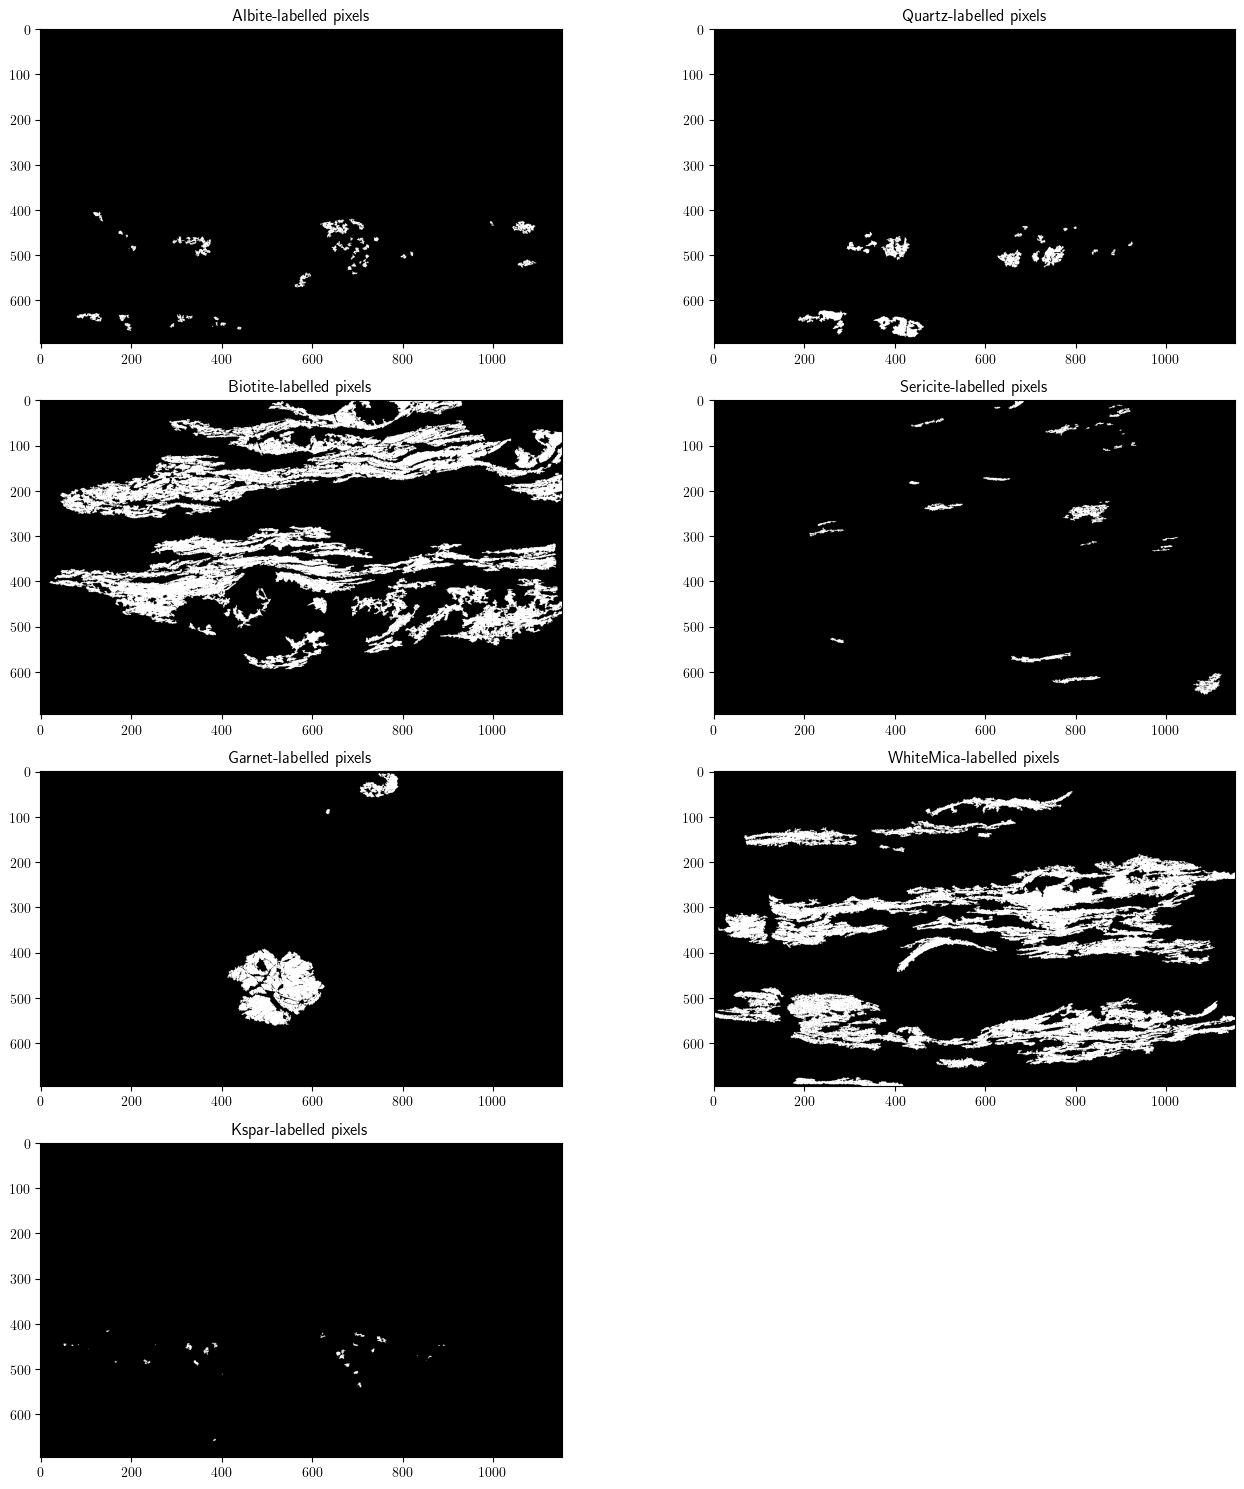

In [10]:
label_arrays = labels_files['TS1A']

fig, ax = plt.subplots(len(label_arrays)//2+1, 2, figsize=(14, 15))
print(len(label_arrays))
for j in range(2):
    for i in range(len(label_arrays)//2+1):
        if (i,j) != (3,1):
            label_name = meta[f'TS1A_labels_names'][i + 4 * j]
            ax[i,j].imshow(label_arrays[i + 4 * j], cmap ='Greys')
            ax[i,j].set_title(f"{label_name}-labelled pixels")
#for k, label in enumerate(label_arrays):
#    ax[k].imshow(label_arrays[k], cmap='gray')
fig.delaxes(ax[3,1])
plt.tight_layout()    
plt.show()

In [11]:
print(np.unique(label_arrays, return_counts=True))

(array([0, 1], dtype=uint8), array([ 342917, 5261563]))


The `Greys` colormap seems to invert the colors of the label arrays; let's take note that tthe _labelled_ pixels are associated with 0's, while the _unlabelled_ pixels associated with 1's.


Let's see if there are any doubly- or un-labelled pixels.
We'll create a label layer with the same dimensions and use `.append` to assign the labels to each pixel, so that we can easily count the number of labels assigned to each one.


We can simply stack the arrays along a third dimension and then check for 0s along the third dimension (at each pixel). Each zero is a label!


In [12]:
# what strings can be placed in the labels_layer?
labels_strings = ['A', 'B', 'G', 'K', 'Q', 'S', 'W']
labels_long_str = ['Ab ', 'Bt ', 'Gt ', 'Ksp', 'Qz ', 'Ser', 'Wm ']


In [13]:
# stack all the arrays along the 0th axis 
stack = np.asarray(labels_files['TS1A'])
shape = meta['TS1A_shape'][0]
print(stack.shape, shape)

# initialize an array of strings in the shape of the image
labels_str_layer = np.asarray([["   "] * shape[1]] * shape[0])

labels_num_layer = np.zeros(shape)
print(labels_str_layer.shape, labels_num_layer.shape)
# iterate over every pixel,
for x in range(shape[0]):
    for y in range(shape[1]):
        # look at every label mask and append it to the labels layer 
        # if it is a 0, otherwise skip it. 
        for lbl_num, mask in enumerate(stack[:,x,y]):
            if mask == 0:
                selected_label = labels_long_str[lbl_num]
                labels_str_layer[x,y] = selected_label
                labels_num_layer[x,y] = lbl_num + 1
                

(7, 695, 1152) (695, 1152)
(695, 1152) (695, 1152)


What we've just done is create a new image the same size as the data by laying the stack of label masks onto it and dropping all the labels into the corresponding coordinates. The result is a 2D array containing all the label layers in one, and with no overlaps; possibly a sign of confident data labelling.


Concatening strings is addmittedly a bit crude here, but fortunately, we can check and see that there are no doubly labelled pixels, so we don't need to worry about it anymore.
We can also see that there are a lot of unlabelled pixels.


In [14]:
print(np.unique(labels_num_layer, return_counts=True)[0])
print(np.unique(labels_num_layer, return_counts=True)[1])

print(np.unique(labels_str_layer, return_counts=True)[0])
print(np.unique(labels_str_layer, return_counts=True)[1])

[0. 1. 2. 3. 4. 5. 6. 7.]
[458181   5506 157524  20174   1014   8558   7164 142519]
['   ' 'Ab ' 'Bt ' 'Gt ' 'Ksp' 'Qz ' 'Ser' 'Wm ']
[458181   5506 157524  20174   1014   8558   7164 142519]


Let's name the unlabelled pixels 'N/A.' In our numerical labelling system, unlabelled pixels correspond to a label of '0'.


In [15]:
labels_str_layer_flat = [i if i != "   " else "N/A" for i in labels_str_layer.ravel()]
labelled_layer = np.reshape(labels_str_layer_flat, shape)
unique_labels, label_counts = np.unique(labelled_layer, return_counts=True)
print(len(labels_str_layer_flat))
print(labelled_layer.shape)
print(unique_labels, label_counts)

800640
(695, 1152)
['Ab ' 'Bt ' 'Gt ' 'Ksp' 'N/A' 'Qz ' 'Ser' 'Wm '] [  5506 157524  20174   1014 458181   8558   7164 142519]


In [16]:
print(np.unique(labels_num_layer, return_counts=True)[0])
print(np.unique(labels_num_layer, return_counts=True)[1])

print(np.unique(labelled_layer, return_counts=True)[0])
print(np.unique(labelled_layer, return_counts=True)[1])

[0. 1. 2. 3. 4. 5. 6. 7.]
[458181   5506 157524  20174   1014   8558   7164 142519]
['Ab ' 'Bt ' 'Gt ' 'Ksp' 'N/A' 'Qz ' 'Ser' 'Wm ']
[  5506 157524  20174   1014 458181   8558   7164 142519]


Let's take a look at the distribution of our labelled data.


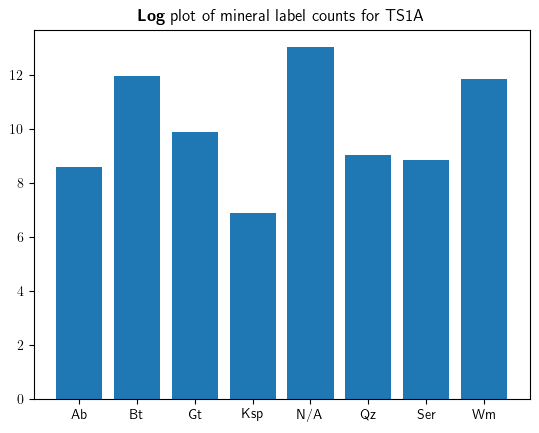

In [17]:
plt.bar(unique_labels, np.log(label_counts))
plt.title(r'$\textbf{Log}$ plot of mineral label counts for TS1A')
plt.show()

Clearly the labelled data is not very balanced. The mineral with the lowest label count is K-spar, with 1014 pixels. The micas have the largest counts, with biotite and white mica at 157524 and 142519, respectively.

There are 458181 unlabelled pixels in the thin section. Out of 800640 total pixels in the image, that's $ 57\% $.


In [18]:
print(np.round(np.max(label_counts)/np.sum(label_counts) * 100, 2),
 f' % of the pixels in this image are unlabelled')

57.23  % of the pixels in this image are unlabelled


Let's take a look at the new labels layer.


['Ab ', 'Bt ', 'Gt ', 'Ksp', 'Qz ', 'Ser', 'Wm ', 'N/A']


ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of labels (7).

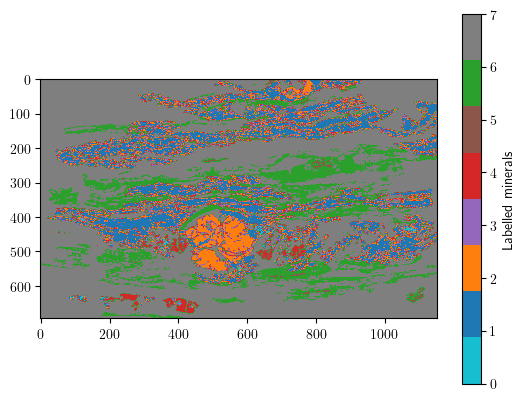

In [19]:

# list of unique strings
unique_strings = np.unique(labelled_layer).tolist()

# remove the element from the list
unique_strings.remove('N/A')
# sort the remaining elements
sorted_list = sorted(unique_strings)
# move the element to the beginning or end
sorted_list.insert(len(sorted_list), 'N/A') 
print(sorted_list)

# Map string labels to numerical values
numeric_labels = np.arange(len(sorted_list))
colors = ['#17becf', '#1f77b4', '#ff7f0e', '#9467bd', '#d62728', '#8c564b', '#2ca02c', '#7f7f7f']
cmap = ListedColormap(colors)
# Create the plot using plt.imshow()
plt.imshow(np.vectorize(dict(zip(sorted_list, numeric_labels)).get)(labelled_layer), cmap=cmap)

# Create a colorbar for reference
cbar = plt.colorbar(ticks=np.arange(len(sorted_list)), label='Labelled minerals', orientation='vertical', spacing='proportional', cmap=cmap)
cbar.set_ticklabels(labels_long_str)

# Display the plot
plt.title(r'Plot of all mineral labels of TS1A')
plt.tight_layout()
plt.show()


This looks good, let's add it to the raw data as a dependent variable to create out labelled dataset.

Remember, the labelled dataset is composed of the entire raw data stack for the thin section, the labelled layer on top, and the x and y coordinates for each pixel. Why do we need the coordinates? Because we are about to flatten the individual 2D arrays into 1D arrays in order to put them into a DataFrame and do more things with them. If we include the coordinates, we can always easily locate a pixel or reshape the array to the original dimension.


In [ ]:
# gather the components
x_coords = np.ndarray.flatten(meta['TS1A_x_coords'])
y_coords = np.ndarray.flatten(meta['TS1A_y_coords'])
labels = np.ndarray.flatten(labelled_layer)

raw_data_stack = np.asarray(raw_files['TS1A'])

# get the element names
element_names = meta['TS1A_channel_names']

labelled_dataset = {}
for layer in range(len(stack[:,0,0])):
    labelled_dataset[f'{element_names[layer]}_channel'] = np.ndarray.flatten(raw_data_stack[layer,:,:])

labelled_dataset.update({'x_coords': x_coords, 'y_coords': y_coords, 'labels': labels})

df = pd.DataFrame(labelled_dataset)

Now we have a **pandas DataFrame** with all of the data we'll need for now! Let's take a look:


In [ ]:
df.head()

,Al_channel,Ca_channel,Ce_channel,Fe_channel,K_channel,Mg_channel,Si_channel,x_coords,y_coords,labels
0,81.0,48.0,5.0,20.0,43.0,4.0,93.0,0.0,0.0,N/A
1,90.0,47.0,4.0,20.0,47.0,1.0,90.0,0.0,1.0,N/A
2,72.0,49.0,7.0,21.0,40.0,1.0,97.0,0.0,2.0,N/A
3,109.0,46.0,3.0,19.0,55.0,9.0,83.0,0.0,3.0,N/A
4,103.0,33.0,3.0,16.0,39.0,5.0,82.0,0.0,4.0,N/A


In [ ]:
df.describe()

,Al_channel,Ca_channel,Ce_channel,Fe_channel,K_channel,Mg_channel,Si_channel,x_coords,y_coords
count,800640.000000,800640.000000,800640.000000,800640.000000,800640.000000,800640.000000,800640.000000,800640.000000,800640.000000
mean,333.793854,71.951431,8.405410,57.761982,150.522705,212.005493,418.593536,347.000000,575.500000
std,117.319511,19.070293,6.658313,37.928856,43.851761,160.439072,117.834061,200.629135,332.553833
min,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,278.000000,64.000000,6.000000,22.000000,140.000000,51.000000,401.000000,173.000000,287.750000
50%,331.000000,72.000000,8.000000,50.000000,166.000000,194.000000,427.000000,347.000000,575.500000
75%,423.000000,79.000000,10.000000,91.000000,179.000000,378.000000,454.000000,521.000000,863.250000
max,964.000000,882.000000,473.000000,415.000000,308.000000,1056.000000,1155.000000,694.000000,1151.000000


In our DataFrame, each row represents a pixel, and all the values in that row are the elements of that pixel's **feature vector**.


| Index # | Pixel_Coordinates | Feature_Vector (contains all features) | Label    |
| ------- | ----------------: | -------------------------------------- | -------- |
| 0       |      (x1, y1, z1) | [feature_vector1]                      | [label1] |
| 1       |      (x2, y2, z2) | [feature_vector2]                      | [label2] |
| ...     |               ... | ...                                    | ...      |
| n       |           (x,y,z) | [ElementA-value, elementB-value]       | Garnet   |


## 4. Save the dataset to a file


The dataset now exists as a pandas DataFrame. Let's store it to an HDF5 file format, which will make it easy to access and combine with future data.


Outdated:
|Pixel|coordinates|Feature vectors|Garnet mask|Staurolite mask|Quartz mask| ...|
|---|---|---|---|---|---|---|
|Index #s| (x,y)|n-D array|1 or 0|1 or 0|1 or 0|---|


We'll want to label the columns


In [ ]:
column_descriptions


NameError: name 'column_descriptions' is not defined

In [ ]:
# create an hdf5 file and populate it with groups for thin sections and a labelled dataset
# in the corresponding group, with a columns attribute for column names and individual column
# attributes for colun descriptions.
def create_hdf5_file(file_path, ts_names, dataframes):
    with h5py.File(file_path, 'w') as hdf_file:
        #for group_name, dataframe in zip(ts_names, dataframes):
        # create a thin section group
        group = hdf_file.create_group(ts_names[0])

        # convert pandas DataFrame to np array
        data_array = df.labels.to_numpy()

        # create a dataset inside the group
        dataset = group.create_dataset()'data', data=data_array)

        # store column labels as an attribute
        dataset.attrs['columns'] = list(dataframes[0].columns)

        # Add a description attribute for each column
        for column_name in df.columns:
            column_description = f"Description for {column_name}"
            dataset.attrs[column_name] = column_description


In [ ]:
print(data)

NameError: name 'data' is not defined

In [ ]:
create_hdf5_file('../Aikin_Data/labelled_data.h5', ts_names, [df])

#### HDF5 metadata crumbs (from the first version)


In [ ]:
# iterate over the thin section filenames
for k, ts in enumerate(ts_fnames):

            column_names_list.append('x_coords')
            column_names_list.append('y_coords')
            column_descriptions.append('x-coordinates of the pixel (row)')
            column_descriptions.append('y-coordinates of the pixel (row)')

        # and flattened
        flattened_map_array = np.ndarray.flatten(single_map_array)
        # normalize the array: (x-mean(x))/std(x)
        normalized_map_array = (flattened_map_array - np.mean(flattened_map_array)/(np.std(flattened_map_array)))
        df = pd.DataFrame(normalized_map_array)
        #print('desc:', df.describe())
        # append the flattened map to the list
        this_ts_data.append(normalized_map_array)
        
        # add the column name to the column_nameList
        column_name = str(element_names[map])
        column_names_list.append(column_name)
        column_description = column_name + ' amount. A flattened, normalized array of the RAW data from EPMA analysis for ' + column_name
        column_descriptions.append(column_description)
        iteration += 1

    # print(column_names_list)
    # print(column_descriptions)
    # this bit lets us label the individual data arrays as dtype fields, so we can call them as dset['field']
    # use column_names_list to define dtype for rec_arr
    rec_dtype = np.dtype({'names':column_names_list, 'formats':[np.float32]*len(column_names_list)}) 
    # make rec_array
    rec_arr = np.rec.fromarrays(this_ts_data, dtype=rec_dtype)

    filename = '/' + this_ts_name + '_data.h5'
    # create an HDF5 file to store the dataframes into in the loop
    datafile = h5py.File(datafolder + filename, 'w') # the 'w' is for 'writing'

    # create a group for each dataset (at this level of complexity we don't need to; all datasets can be in the root folder)
    #raw_datagroup = datafile.create_group('RAW')

    # add the data to the hpf5 file by creating a dataset in the RAW data group for this thin section
    dset = datafile.require_dataset('RAW', shape= rec_arr.shape, dtype=rec_arr.dtype, data=rec_arr)
    # let's add a column descriptor attribute for each column in the dataset:
    for name, desc in zip(column_names_list, column_descriptions):
        attribute_name = name + '_description'
        dset.attrs[attribute_name] = desc
        #print(dset.attrs[attribute_name])
    dset.attrs['original_dimensions'] = single_map_array.shape
    dset.attrs['columns'] = column_names_list
    dset.attrs['name'] = this_ts_name + '_RAW_data'
    dset.attrs['description'] = 'This dataset contains 9 flattened EPMA elemental map arrays of ' + this_ts_name + '. This is the raw data. Do not overwrite.'
    dset.attrs['length'] = flattened_map_array.shape
    print(dset.attrs.keys())
    #print(dset['Al'].shape)
    #print(dset.attrs.keys())
    # Add descriptions as attributes to each column
datafile.close()

In [ ]:
# now we can explore the data like this:

# open file
with h5py.File(datafolder + filename, 'r') as datafile:

    # get keys
    print('The root folder of the data file contains:', datafile.keys())

    # get dataset
    dataset = datafile['RAW']
    print('These are the attributes of the dataset:', dataset.attrs.keys())

    # get dataset names
    column_names = dataset.dtype.names
    print('The column names of the RAW dataset are: ', column_names)

    # see a column
    print(f'The aluminum column of the dataset['Al'])
    # see a pixel vector
    for pixel in range(10):
        print('Pixel @ (', dataset['x_coords'][pixel], ',', dataset['y_coords'][pixel], '):', dataset[pixel])

    # show the data
    # images are flattened, so reshape
    width = (dataset['x_coords'].max() + 1).astype(int)
    height = (dataset['y_coords'].max() + 1).astype(int)
    data_2d = dataset['Al'].reshape(width, height)
    plt.imshow(data_2d)
    plt.show()

In [ ]:
# first we load the binary masks into a list, with another list for the names
#datafile.close()
datafolder = './Aikin_Data'

# get all thin section folder names
ts_names = sorted([entry for entry in os.listdir(datafolder) 
                if os.path.isdir(os.path.join(datafolder, entry)) and 'DS_Store' not in entry])
number_of_ts = len(ts_names)


# now we can use the names list to open the files and the stacks list to store them. 
# for each thin section folder:
for ts in range(1):
    
    # get the name of the thin section
    this_ts_name = ts_names[ts]
    # initialize a list to contain each map as a 1D array. 
    this_ts_data = []

    # get all the thin section's mask filenames, then remove any 
    mask_names = sorted([entry for entry in os.listdir(os.path.join(datafolder, this_ts_name, 'labels'))
                if 'Mineralmasks-' in entry])

    ### we'll want to clean up the filenames to make nice dataset labels
    # What are the mineral names for each mask?
    # make a list of mineral names        
    mineral_names = []
    # find the mineral names in each filename and add the mineral name to the list
    filter_list = ['albite', 'biotite', 'garnet', 'kspar', 'quartz', 'sericite', 'whitemica']
    for mask_name in mask_names:
        for mineral in filter_list:
            if mineral.lower() in mask_name.lower():
                    if mineral == filter_list[-1]:
                        mineral_names.append('muscovite')
                    else:
                        mineral_names.append(mineral)
        
    print(mineral_names)
    # iteration counter serves to allow coordinate vectors to be generated during the first iteration only.if iteration 
    iteration = 0
    # create list of column names
    column_names_list = []
    column_descriptions = []
    # for each mask, load the file, turn it into an array, and append it to the list.
    for mask in mask_names:
        # open the mask
        filename = mask_names[iteration]
        rootfolder = os.path.join('./Aikin_Data', this_ts_name, 'labels')
        single_ts_mask = Image.open(os.path.join(rootfolder, filename))
        #plt.imshow(single_ts_mask, cmap='gray')  # Adjust the colormap if needed

        # as numpy array
        single_mask_array = np.asarray(single_ts_mask)
        
        # add a coordinates vector list (x,y,z=channel) in the first iteration
        if iteration == 0:

            # get the coordinates of each pixel
            x_coords = []
            y_coords = []
            x, y = single_mask_array.shape
            for i in range(x):
                for j in range(y):
                        coords = [i,j]
                        x_coords.append(coords[0])
                        y_coords.append(coords[1])

            x_coords = np.array(x_coords, dtype=np.float32)
            y_coords = np.array(y_coords, dtype=np.float32)

            this_ts_data.append(x_coords)
            this_ts_data.append(y_coords)
            column_names_list.append('x_coords')
            column_names_list.append('y_coords')
            column_descriptions.append('x-coordinates of the pixel (row)')
            column_descriptions.append('y-coordinates of the pixel (row)')
            
        # and flattened
        flattened_mask_array = np.ndarray.flatten(single_mask_array)

        # pixels that are part of a mineral mask are currently '0', and pixels that are not the mineral are '1'.
        # in order to apply the mask to the raw data, we'll need to first flip that (so that non-mask pixels can be removed as 0s)
        flattened_mask_array = flattened_mask_array * (-1) + 1
        # append the flattened map to the list
        this_ts_data.append(flattened_mask_array)
        
        # add the column name to the column_nameList
        column_name = str(mineral_names[iteration]) + '_mask'
        column_names_list.append(column_name)
        column_description = 'A binary mask, or raster of 0s and 1s, for ' + mineral_names[iteration] + ' in thin section: ' + this_ts_name + '. Created manually by N. Aikin. 0 = IS NOT ' + mineral_names[iteration] + ', while 1 = IS ' + mineral_names[iteration]
        column_descriptions.append(column_description)
        iteration += 1
    #print(column_names_list)
    #print(mask_names)
    #print(this_ts_data)
    # this bit lets us label the individual data arrays as dtype fields, so we can call them as dset['field']
    # use column_names_list to define dtype for rec_arr
    ds_dt = np.dtype({'names':column_names_list,'formats':[float]*len(column_names_list)})
    # make rec_array
    if len(column_names_list) != 0:
        rec_arr = np.rec.fromarrays(this_ts_data, dtype=ds_dt)

    filename = '/' + this_ts_name + '_data.h5'
    # create an HDF5 file to store the dataframes into in the loop
    datafile = h5py.File(datafolder + filename, 'a') # the 'a' is for edit mode
    # create a group for each dataset (at this level of complexity we don't need to; all datasets can be in the root folder)
    #raw_datagroup = datafile.create_group('labels')

    # add the data to the hpf5 file by creating a dataset in the RAW data group for this thin section
    dset = datafile.require_dataset('labels', shape= rec_arr.shape, dtype=rec_arr.dtype, data=rec_arr)
    # let's add column descriptor attributes, one for each column/mineral mask. 
    for name, desc in zip(column_names, column_descriptions):
        attribute_name = name + '_description'
        dset.attrs[attribute_name] = desc
        print(dset.attrs[attribute_name])
    dset.attrs['original_dimensions'] = single_mask_array.shape
    dset.attrs['columns'] = column_names_list
    dset.attrs['name'] = this_ts_name + 'labels'
    dset.attrs['description'] = 'This dataset contains 7 flattened binary rasters of the same shape as the RAW data.' + 'Currently, this dataset only exists for ' + this_ts_name + '. This dataset is used to filter the map data by element, which will serve as labelled model training data'
    dset.attrs['length'] = flattened_mask_array.shape
    print(datafile.keys())
    datafile.close()


In [ ]:
datafile.close()
# now we can explore the data like this:

# open file
with h5py.File(datafolder + filename, 'r') as datafile:

    # get keys
    print(datafile.keys())
    # get dataset
    dataset = datafile['binary_masks']
    # get dataset names
    column_names = dataset.dtype.names
    print(column_names)
    # see a column
    print(dataset['albite_mask'])
    # see a pixel vector
    for pixel in range(10):
        print('Pixel @ (', dataset['x_coords'][pixel], ',', dataset['y_coords'][pixel], '):', dataset[pixel])

    # show the data
    # images are flattened, so reshape
    width = (dataset['x_coords'].max() + 1).astype(int)
    height = (dataset['y_coords'].max() + 1).astype(int)
    data_2d = dataset['biotite_mask'].reshape(width, height)
    plt.imshow(data_2d, cmap='gray')
    plt.show()
    print(datafile.keys())

In [ ]:
#datafile.close()
# next, we'll want to open the file, access the raw data and the binary masks, and multiply them together into new masked datasets.
datafolder = './Aikin_data'
filepath = '/78.7-10-1_Hot_data.h5'

# open the file
with h5py.File(datafolder + filepath, 'a') as datafile:

    # create the group
    maskedmaps_group = datafile.require_group('masked_maps')
    maskedmaps_group.attrs['description'] = ' This group contains the masked element maps. In this group there is a dataset ' + ' for each of seven minerals, and each dataset contains 9 masked, flattened element maps.'
    # get the raw and mask datasets
    raw_ds = datafile['RAW']
    bm_ds = datafile['labels']

    # Extract column names from their dtypes
    raw_column_names = raw_ds.dtype.names
    bm_column_names = bm_ds.dtype.names
    
    # for each mineral mask, multiply every column of the raw data and save it to a new mask. 
    # name the new dataset after the mineral mask, and the columns after the map names.
    iteration = 0
    for mask in bm_column_names[2:]:
        this_mask = bm_ds[mask]
        masked_map_list = []
        new_column_names = []
        new_column_descriptions = []
        masked_map_list.append(np.asarray(raw_ds['x_coords']))
        masked_map_list.append(np.asarray(raw_ds['y_coords']))
        new_column_names.append('x_coords')
        new_column_names.append('y_coords')
        new_column_descriptions.append('x-coordinates of the pixel (row)')
        new_column_descriptions.append('y-coordinates of the pixel (row)')
        for map in raw_column_names[2:]:
            this_map = raw_ds[map]
            masked_map = this_map * this_mask
            masked_map_list.append(masked_map)
            column_name = 'masked_' + map
            new_column_names.append(map)
            mineral_name = mask[:-5]
            new_column_description = 'Masked ' + map + ' data for the mineral ' + mineral_name + '. Coordinate information is retained, but all "IS NOT" ' + mineral_name + ' pixels are removed.'
            new_column_descriptions.append(new_column_description)
            #print(mask, map, np.count_nonzero(masked_map))
    
        #removed this for image display (this cuts out all the zero pixels)
        # filtered_masked_map_list = []
        # # remove elements where this_mask is 0
        # for array in masked_map_list:
        #     filtered_array = array[this_mask != 0]
        #     filtered_masked_map_list.append(filtered_array)

        # we can check to make sure this worked
        # print('m0:', masked_map_list[0].shape)
        # print('m1:', masked_map_list[1].shape)
        # print('m2:', masked_map_list[1].shape)
        # print('f0:', filtered_masked_map_list[0].shape)
        # print('f1:', filtered_masked_map_list[1].shape)
        # print('f2:', filtered_masked_map_list[1].shape)
        

        # this bit lets us label the individual data arrays as dtype fields, so we can call them as dset['field']
        # use column_names_list to define dtype for rec_arr
        ds_dt = np.dtype({'names':new_column_names,'formats':[np.float32]*len(new_column_names)})
        # make rec_array
        rec_arr = np.rec.fromarrays(masked_map_list, dtype=ds_dt)

       
        # add the data to the hpf5 file by creating a dataset in the RAW data group for this thin section 
        # (we use 'require' so that it's only created if it doesn't exist yet)
        dataset_name = mask[:-5] + '_maps'
        masked_dset = maskedmaps_group.require_dataset(dataset_name, shape=rec_arr.shape, dtype=rec_arr.dtype, data=rec_arr)
        
        bmasks = datafile['labels']
        od = list(bmasks.attrs['original_dimensions'])
        print(od)
        
        # add a descriptor attribute for each column:
        for name, desc in zip(new_column_names, new_column_descriptions):
            attribute_name = name + '_description'
            masked_dset.attrs[attribute_name] = desc
            print(masked_dset.attrs[attribute_name])
        masked_dset.attrs['original_dimensions'] = (od[0], od[1]) # needs fixed
        masked_dset.attrs['columns'] = new_column_names
        masked_dset.attrs['name'] =  'masked_element_maps_training_data'
        masked_dset.attrs['description'] = 'This dataset contains 9 elemental maps that have been masked by ' + mask + 'of thin section Hot block 1.' + 'This is the training data.'
        masked_dset.attrs['length'] = masked_map_list[0].shape
        
        print(masked_dset.attrs.keys())
        #print(masked_dset.dtype.names)
    print(maskedmaps_group.keys())
datafile.close()


In [ ]:

filepath = './Aikin_Data/78.7-10-1_Hot_data.h5'
groupname = 'masked_maps'
with h5py.File(filepath, 'r') as datafile:
    print(datafile.keys())
    group = datafile[groupname]
 
    dset_names = list(group.keys())
    dset_values = list(group.values())
    print(dset_values)

In [ ]:
### I believe this block is a redundant version of the block above from the draftin process, but I lost track of it. Revisit if there are issues. 
# # next, we'll want to open the file, access the raw data and the binary masks, and multiply them together into new masked datasets.
# datafolder = './Aikin_data'
# filepath = '/78.7-10-1_Hot_data.h5'
# #open the file
# with h5py.File(datafolder + filepath, 'a') as datafile:
#     # get the mask dataset
#     bm_ds = datafile['binary_masks']

#     # Extract column names from their dtypes
#     bm_column_names = bm_ds.dtype.names
#     mineral_names = bm_column_names[2:]
#     width = (bm_ds['x_coords'].max() + 1).astype(int)
#     height = (bm_ds['y_coords'].max() + 1).astype(int)
#     allMasks_array = np.zeros((width, height), dtype=object)
#     iteration = 0
#     for mask in mineral_names:
#         mask_array = bm_ds[mask]
            
#         x = bm_ds['x_coords'].astype(int)
#         y = bm_ds['y_coords'].astype(int)
            
#         mask_mineral = mask.replace(' mask', '')
#         for pixel, value in enumerate(mask_array):
#             xc = x[pixel].item()
#             yc = y[pixel].item()
#             if mask_array[pixel] == 1:
#                 allMasks_array[xc, yc] = iteration
#         iteration += 1

#     print(type(allMasks_array))

#     data_flat = allMasks_array.flatten()
#     data_final = data_flat.astype(int)

    
#     x_coords = bm_ds[bm_column_names[0]]
#     y_coords = bm_ds[bm_column_names[1]]
#     print(x_coords)
#     print(y_coords)

#     data = [x_coords, y_coords, data_flat]

#     # this bit lets us label the individual data arrays as dtype fields, so we can call them as dset['field']
#     # use column_names_list to define dtype for rec_arr
#     ds_dt = np.dtype({'names':['x_coords', 'y_coords', 'mineral_labels'],'formats':[np.float32]*3})
#     # make rec_array
#     rec_arr = np.rec.fromarrays(data, dtype=ds_dt)

#     # save the new dataset to the hdf5 file under 'masked_maps'
#     datagroup = datafile['masked_maps']
#     dataset_name = 'mineral_labels'
#     masked_dset = datagroup.require_dataset(dataset_name, shape=rec_arr.shape, dtype=rec_arr.dtype, data=rec_arr)
#     #print(masked_dset.dtype.names)
#     print(datagroup.keys())
# datafile.close()
# print(mineral_names)

In [ ]:
datafile.close()
# now we can explore the data like this:
filepath = './Aikin_Data/78.7-10-1_Hot_data.h5'
# open file
with h5py.File(filepath, 'r') as datafile:

    # get keys
    print(datafile.keys())
    # get dataset
    datagroup = datafile['masked_maps']
    print(datagroup.keys())
    dataset = datagroup['biotite_maps']
    # get dataset names
    column_names = dataset.dtype.names
    print(column_names)
    # see a column
    print(dataset['Al'])
    # see a pixel vector
    for pixel in range(10):
        print('Pixel @ (', dataset['x_coords'][pixel], ',', dataset['y_coords'][pixel], '):', dataset[pixel])

    # show the data
    # images are flattened, so reshape
    width = (dataset['x_coords'].max() + 1).astype(int)
    height = (dataset['y_coords'].max() + 1).astype(int)
    #data_2d = dataset['Al_map'].reshape(width, height)
    #plt.imshow(data_2d, cmap='gray')
    #plt.show()
    print(datafile.keys())
datafile.close()

## -1. Summary

The code works cleanly up to this point. It has now created:

-   An HDF5 file containing a group for each thin section. The TS1A group contains a labelled dataset composed of a 2-D array, where variables are columns and instances/pixels are rows. The columns include the dependent variables `x_coords`, `y_coords`, and `labels', and the independent variables of all the raw element channels.
-   A pandas DataFrame containing the dataset.

**_Obsolete (old version)_**

-   An HDF5 file for each thin section containing:
    -   **Raw data**: A 'RAW maps' dataset containing:
        -   A flattened np.array of each element map (columns), with labels
        -   A vector of element values for each pixel (rows)
    -   A 'binary masks' dataset containing
        -   A partial binary mask for each major mineral for data labelling
    -   **Labelled training data**: A 'masked maps' group containing:
        -   A 'mineral mask' dataset for each mineral mask containing:
            -   A masked flattened np.array of each element map (columns), with labels
            -   A vector of element values for each pixel (rows)
